In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')
directory = "/content/drive/My Drive/DataC102 Proj"

dem_cat = pd.read_csv("%s/dem-cat.csv" % directory)
rep_test = pd.read_csv(('%s/rep_cands.csv' % directory))

Mounted at /content/drive


# Frame Cleanup

In [6]:
# Cleaning dem_cat DataFrame
dem_cat['Won Primary'] = dem_cat['Won Primary'].map({'Yes':1,'No':0})
dem_cat['Race'] = dem_cat['Race'].map({'White':1,'Nonwhite':0})
dem_cat['Party'] = 'Dem'
dem_cat.head()

,Unnamed: 0,Won Primary,Race,Veteran?,LGBTQ?,Elected Official?,Self-Funder?,STEM?,Obama Alum?,Party Support?,...,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?,last_name,first_initial,Party
0,6,NaN,NaN,No,No,No,No,Yes,No,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mcconnell,L,Dem
1,7,NaN,NaN,Yes,No,No,No,No,No,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,jr.,R,Dem
2,8,NaN,NaN,Yes,No,No,No,No,No,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,williams,A,Dem
3,9,NaN,NaN,No,No,No,No,No,No,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,isner,T,Dem
4,10,NaN,NaN,No,No,No,No,Yes,No,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,winfrey,A,Dem


In [7]:
# Cleaning rep_test DataFrame
rep_test['Won Primary'] = rep_test['Won Primary'].map({'Yes':1, 'No':0})
rep_test['Race Type'] = rep_test['Race Type'].map({'Special':1, 'Regular':0})
rep_test['Primary Status'] = rep_test['Primary Status'].map({'Advanced':1, 'Lost':0, 'On the Ballot':0})
rep_test['Party'] = 'Rep'
rep_test.head()

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Primary %,...,Right to Life Endorsed?,Susan B. Anthony Endorsed?,Club for Growth Endorsed?,Koch Support?,House Freedom Support?,Tea Party Endorsed?,Main Street Endorsed?,Chamber Endorsed?,No Labels Support?,Party
0,Mike Dunleavy,AK,Governor of Alaska,Governor,0.0,8/21/18,1,None,On the Ballot,61.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rep
1,Michael Sheldon,AK,Governor of Alaska,Governor,0.0,8/21/18,0,None,None,2.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rep
2,Mead Treadwell,AK,Governor of Alaska,Governor,0.0,8/21/18,0,None,None,31.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rep
3,Darin Colbry,AK,Governor of Alaska,Governor,0.0,8/21/18,0,None,None,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rep
4,Thomas Gordon,AK,Governor of Alaska,Governor,0.0,8/21/18,0,None,None,1.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rep


# Functions

In [8]:
def CleanFrame(dataframe):
  dataframe = dataframe.replace({'Yes':1,'No':0})
  return dataframe

In [9]:
def ShuffleDiff(data, col):
  differences = []
  seed = np.arange(1000)

  for i in np.arange(1000):
      shuffled_labels = data.sample(frac = 1,replace = False, random_state = seed[i])[col].reset_index(drop = True)
      data["Shuffled Label"] = shuffled_labels
      new = data[['Shuffled Label', 'Won Primary']]
      means = new.groupby('Shuffled Label').mean()
      means_diff = float(means.iloc[0] - means.iloc[1])
      differences = np.append(differences, means_diff)

  return differences

In [10]:
def pscore(diffs, props, iter_lim=1000):
  count = 0

  for i in diffs:
    if i <= props:
      count += 1

  p_value = count/iter_lim
  return p_value

In [11]:
def GetPValue(table, prim_col, col_to_compare):
  
  reduced = table[[prim_col, col_to_compare]].replace({'Yes':1, 'No':0}).dropna().reset_index(drop = True)
  obs_prop = float(reduced.groupby(col_to_compare).mean().iloc[0] - reduced.groupby(col_to_compare).mean().iloc[1])

  differences = ShuffleDiff(reduced, col_to_compare)

  p_val = pscore(differences, obs_prop)

  return p_val, obs_prop, differences


In [12]:
def plotting_temp(diffs, obs, col_to_compare):
  plt.hist(diffs, density=True)
  plt.suptitle('Prediction under the Null Hypothesis for '+col_to_compare)
  plt.xlabel("Difference in proportion")
  plt.ylabel("Percent Per Unit")
  plt.axvline(x = obs, color = 'r', label = 'Observed difference in means for '+col_to_compare)

# Group Hypothesis: Candidate Attributes and Primary Results

In [13]:
dem_cand_attributes = dem_cat[['Won Primary', 'Race', 'Veteran?', 'LGBTQ?', 'Self-Funder?', 'STEM?', 'Obama Alum?']].fillna(0)
dem_cand_attributes = CleanFrame(dem_cand_attributes)
dem_cand_attributes.head()

,Won Primary,Race,Veteran?,LGBTQ?,Self-Funder?,STEM?,Obama Alum?
0,0.0,0.0,0,0,0,1,0
1,0.0,0.0,1,0,0,0,0
2,0.0,0.0,1,0,0,0,0
3,0.0,0.0,0,0,0,0,0
4,0.0,0.0,0,0,0,1,0


**Hypothesis #1: Race** 

In [15]:
p_val_race, obs_race, diff_race = GetPValue(dem_cand_attributes, 'Won Primary', 'Race') ###
print(p_val_race, obs_race)

IndexError: ignored

In [ ]:
plotting_temp(diff_race, obs_race, 'Race')

In [ ]:
GetPValue(dem_cand_attributes, 'Won Primary', 'Veteran?')[:2]

In [ ]:
GetPValue(dem_cand_attributes, 'Won Primary', 'LGBTQ?')[:2]

In [ ]:
GetPValue(dem_cand_attributes, 'Won Primary', 'Self-Funder?')[:2]

In [ ]:
GetPValue(dem_cand_attributes, 'Won Primary', 'STEM?')[:2]

**Hypothesis #2: Obama Alumni**

In [ ]:
p_val_Obama, obs_Obama, diff_Obama = GetPValue(dem_cand_attributes, 'Won Primary', 'Obama Alum?') ##
print(p_val_Obama, obs_Obama)

In [ ]:
plotting_temp(diff_Obama, obs_Obama, 'Obama Alumn')

# Group Hypothesis: Political Figure Support and Primary Results

In [ ]:
dem_people_endorsements = dem_cat[['Won Primary', 'Emily Endorsed?', 'Biden Endorsed?', 'Warren Endorsed? ', 'Sanders Endorsed?']].fillna(0)
dem_people_endorsements = CleanFrame(dem_people_endorsements)
dem_people_endorsements.head()

,Won Primary,Emily Endorsed?,Biden Endorsed?,Warren Endorsed?,Sanders Endorsed?
0,0,0,0,0,0
1,1,0,0,0,0
2,0,0,0,0,0
3,1,0,0,0,0
4,0,0,0,0,0


In [ ]:
GetPValue(dem_people_endorsements, 'Won Primary', 'Emily Endorsed?')[:2]

(0.0, -0.40887981987053196)

**Hypothesis #3: Biden Endorsed**

In [ ]:
p_val_Biden, obs_Biden, diff_Biden = GetPValue(dem_people_endorsements, 'Won Primary', 'Biden Endorsed?') ## 0.5
print(p_val_Biden, obs_Biden)

0.0 -0.6882352941176471


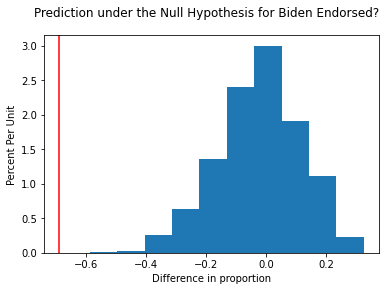

In [ ]:
plotting_temp(diff_Biden, obs_Biden, 'Biden Endorsed?')

In [ ]:
GetPValue(dem_people_endorsements, 'Won Primary', 'Warren Endorsed? ')[:2]

(0.016, -0.6822157434402332)

**Hypothesis #4: Sanders Endorsed**

In [ ]:
p_val_Sanders, obs_Sanders, diff_Sanders = GetPValue(dem_people_endorsements, 'Won Primary', 'Sanders Endorsed?') ## 0.5
print(p_val_Sanders, obs_Sanders)

0.298 -0.17982456140350878


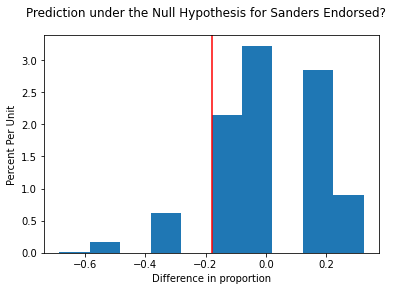

In [ ]:
plotting_temp(diff_Sanders, obs_Sanders, 'Sanders Endorsed?')

In [ ]:
rep_people_endorsements = rep_test[['Won Primary', 'Trump Endorsed?', 'Bannon Endorsed?', 'Susan B. Anthony Endorsed?', 'Koch Support?']].fillna(0)
rep_people_endorsements = CleanFrame(rep_people_endorsements)
rep_people_endorsements.head()

,Won Primary,Trump Endorsed?,Bannon Endorsed?,Susan B. Anthony Endorsed?,Koch Support?
0,1,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


**Hypothesis #5: Trump Endorsed**

In [ ]:
p_val_Trump, obs_Trump, diff_Trump = GetPValue(rep_people_endorsements, 'Won Primary', 'Trump Endorsed?') # 0.5
print(p_val_Trump, obs_Trump)

0.0 -0.5785220296837361


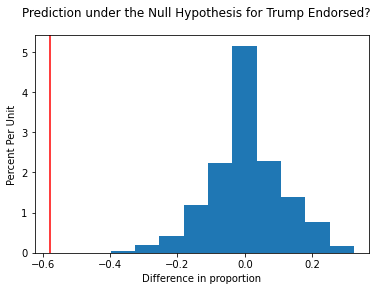

In [ ]:
plotting_temp(diff_Trump, obs_Trump, 'Trump Endorsed?')

**Hypothesis #6: Bannon Endorsed**

In [ ]:
p_val_Bannon, obs_Bannon, diff_Bannon = GetPValue(rep_people_endorsements, 'Won Primary', 'Bannon Endorsed?')
print(p_val_Bannon, obs_Bannon)

0.009 -0.43798955613577023


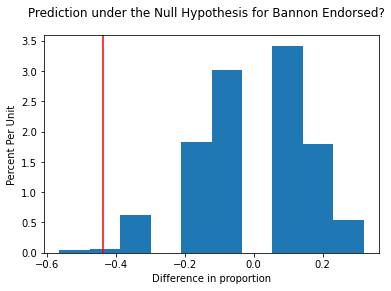

In [ ]:
plotting_temp(diff_Bannon, obs_Bannon, 'Bannon Endorsed?')

In [ ]:
GetPValue(rep_people_endorsements, 'Won Primary', 'Susan B. Anthony Endorsed?')[:2]

(0.029, -0.21148613442945635)

In [ ]:
GetPValue(rep_people_endorsements, 'Won Primary', 'Koch Support?')[:2]

(0.0, -0.5556820337696831)

# Group Hypothesis : Group Endorsements and Primary Results

In [ ]:
dem_group_support = dem_cat[['Won Primary', 'Party Support?', 'Our Revolution Endorsed?', 'Justice Dems Endorsed?', 'PCCC Endorsed?', 'Indivisible Endorsed?', 'WFP Endorsed?', 'No Labels Support?']].fillna(0)
dem_group_support = CleanFrame(dem_group_support)
dem_group_support.head()

,Won Primary,Party Support?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,No Labels Support?
0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0


**Hypothesis #7: Democratic Party Endorsed**

In [ ]:
p_val_dem, obs_dem, diff_dem = GetPValue(dem_group_support, 'Won Primary', 'Party Support?')  ##
print(p_val_dem, obs_dem)

0.0 -0.6620923474329996


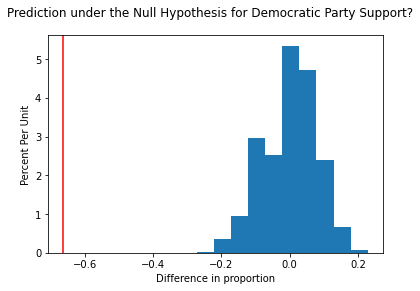

In [ ]:
plotting_temp(diff_dem, obs_dem, 'Democratic Party Support?')

In [ ]:
GetPValue(dem_group_support, 'Won Primary', 'Our Revolution Endorsed?')[:2]

(0.49, -0.007859505783619325)

In [ ]:
GetPValue(dem_group_support, 'Won Primary', 'Justice Dems Endorsed?')[:2]

(0.675, 0.018633540372670787)

**Hypothesis #9: PCCC Endorsed**

In [ ]:
p_val_pccc, obs_pccc, diff_pccc = GetPValue(dem_group_support, 'Won Primary', 'PCCC Endorsed?') ##
print(p_val_pccc, obs_pccc)

0.003 -0.4358407079646018


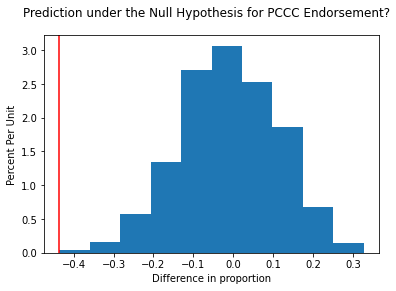

In [ ]:
plotting_temp(diff_pccc, obs_pccc, 'PCCC Endorsement?')

In [ ]:
GetPValue(dem_group_support, 'Won Primary', 'Indivisible Endorsed?')[:2]

(0.0, -0.37500000000000006)

**Hypothesis #10: WFP Endorsed**

In [ ]:
p_val_WFP, obs_WFP, diff_WFP = GetPValue(dem_group_support, 'Won Primary', 'WFP Endorsed?') ##
print(p_val_WFP, obs_WFP)

0.009 -0.2518740629685157


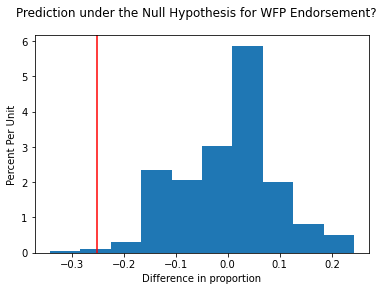

In [ ]:
plotting_temp(diff_WFP, obs_WFP, 'WFP Endorsement?')

In [ ]:
GetPValue(dem_group_support, 'Won Primary', 'No Labels Support?')[:2]

(1.0, 0.3226744186046512)

In [ ]:
rep_group_support = rep_test[['Won Primary', 'Rep Party Support?', 'Great America Endorsed?', 'NRA Endorsed?', 'Right to Life Endorsed?', 
                                    'Club for Growth Endorsed?', 'House Freedom Support?', 'Tea Party Endorsed?', 'Main Street Endorsed?', 'Chamber Endorsed?', 'No Labels Support?']].fillna(0)
rep_group_support = CleanFrame(rep_group_support)
rep_group_support.head()

,Won Primary,Rep Party Support?,Great America Endorsed?,NRA Endorsed?,Right to Life Endorsed?,Club for Growth Endorsed?,House Freedom Support?,Tea Party Endorsed?,Main Street Endorsed?,Chamber Endorsed?,No Labels Support?
0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0


**Hypothesis #9: Republican Party Endorsed**

In [ ]:
p_val_rep, obs_rep, diff_rep = GetPValue(rep_group_support, 'Won Primary', 'Rep Party Support?') ##
print(p_val_WFP, obs_WFP)

0.009 -0.2518740629685157


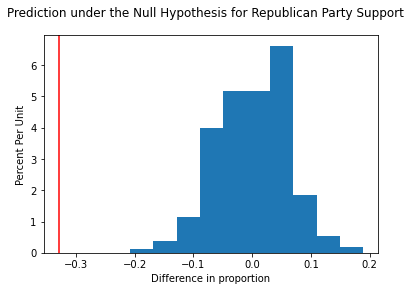

In [ ]:
plotting_temp(diff_rep, obs_rep, 'Republican Party Support')

In [ ]:
GetPValue(rep_group_support, 'Won Primary', 'Great America Endorsed?')[:2]

(0.035, -0.40137828273421494)

**Hypothesis #11: NRA Endorsed**

In [ ]:
p_val_nra, obs_nra, diff_nra = GetPValue(rep_group_support, 'Won Primary', 'NRA Endorsed?') ##
print(p_val_nra, obs_nra)


0.048 -0.2595864661654135


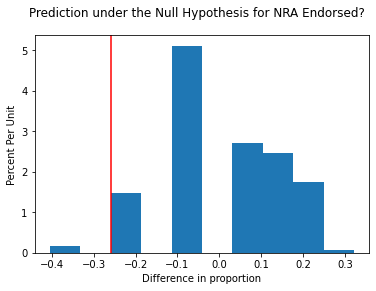

In [ ]:
plotting_temp(diff_nra, obs_nra, 'NRA Endorsed?')

**Hypothesis #12: National Right to Life Commitee Endorsed**

In [ ]:
p_val_life, obs_life, diff_life = GetPValue(rep_group_support, 'Won Primary', 'Right to Life Endorsed?') ##
print(p_val_life, obs_life)

0.01 -0.14308880308880306


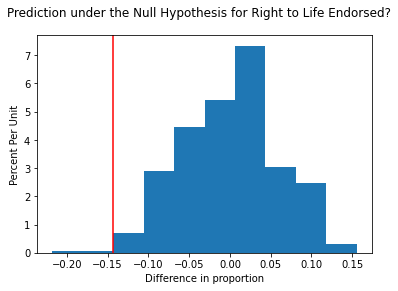

In [ ]:
plotting_temp(diff_life, obs_life, 'Right to Life Endorsed?')

In [ ]:
GetPValue(rep_group_support, 'Won Primary', 'Club for Growth Endorsed?')[:2]

(0.003, -0.3109466894327452)

In [ ]:
GetPValue(rep_group_support, 'Won Primary', 'House Freedom Support?')[:2]

(0.114, -0.18684210526315792)

In [ ]:
GetPValue(rep_group_support, 'Won Primary', 'Tea Party Endorsed?')[:2]

(0.01, -0.3149736147757256)

In [ ]:
GetPValue(rep_group_support, 'Won Primary', 'Main Street Endorsed?')[:2]

(0.007, -0.3379438961846298)

In [ ]:
GetPValue(rep_group_support, 'Won Primary', 'Chamber Endorsed?')[:2]

(0.066, -0.3116840731070496)

In [ ]:
GetPValue(rep_group_support, 'Won Primary', 'No Labels Support?')[:2]

(0.539, -0.18393782383419688)

In [ ]:
dem_veteran_history = dem_cat[['Won Primary', 'Veteran?', 'VoteVets Endorsed?']].fillna(0)
dem_veteran_history = CleanFrame(dem_veteran_history)
dem_veteran_history.head()

,Won Primary,Veteran?,VoteVets Endorsed?
0,0,0,0
1,1,1,0
2,0,1,0
3,1,0,0
4,0,0,0


In [ ]:
GetPValue(dem_veteran_history, 'Won Primary', 'Veteran?')[:2]

(0.552, 0.0011630912380460323)

In [ ]:
GetPValue(dem_veteran_history, 'Won Primary', 'VoteVets Endorsed?')[:2]

(0.01, -0.24333836098541983)

(array([0.23259689, 0.86393129, 3.09021578, 4.12028771, 7.07759098,
        8.73899732, 4.25320021, 3.55540955, 1.03007193, 0.26582501]),
 array([-0.15488498, -0.12479   , -0.09469501, -0.06460003, -0.03450504,
        -0.00441005,  0.02568493,  0.05577992,  0.0858749 ,  0.11596989,
         0.14606487]),
 <a list of 10 Patch objects>)

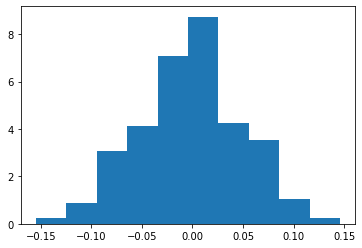

In [ ]:
diff_dem_veteran_history = ShuffleDiff(dem_veteran_history, 'Veteran?')
plt.hist(diff_dem_veteran_history, density=True)

# Multiple Hypothesis Corrections

In [ ]:
all_p_values = [p_val_race, p_val_Obama, p_val_Biden, p_val_Sanders, p_val_Trump, p_val_Bannon, p_val_dem, p_val_rep, p_val_pccc, p_val_WFP, p_val_nra, p_val_life]
all_p_values.sort()
all_p_values

[0.0, 0.0, 0.0, 0.0, 0.003, 0.009, 0.009, 0.01, 0.048, 0.171, 0.28, 0.298]

In [ ]:
N = 12
k = np.arange(1, 13)
alpha = 0.05
bonferroni = alpha/N
b_h = k/N * alpha

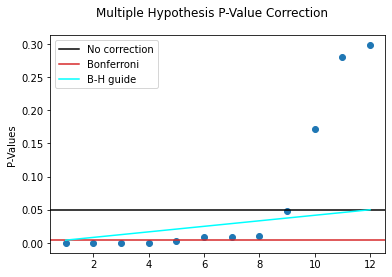

In [ ]:
plt.scatter(k, all_p_values)
plt.axhline(alpha, label='No correction', color='black')
plt.axhline(alpha / N, label='Bonferroni', color='tab:red')
plt.plot(k, k/N * alpha, label='B-H guide', color='cyan')
plt.suptitle('Multiple Hypothesis P-Value Correction')
plt.ylabel("P-Values")
plt.legend();

In [ ]:
bonferroni

0.004166666666666667

In [ ]:
b_h

array([0.00416667, 0.00833333, 0.0125    , 0.01666667, 0.02083333,
       0.025     , 0.02916667, 0.03333333, 0.0375    , 0.04166667,
       0.04583333, 0.05      ])